#  Recreate heatmaps of the Immunity paper with newly defined population (but SAME genes as in that paper)

## Import statements

In [1]:
import os,sys
import datetime

In [2]:
import scanpy as sc
sc.logging.print_versions()
sc.logging.print_memory_usage()
sc.settings.verbosity = 2

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.7 numpy==1.15.4 scipy==1.3.1 pandas==0.23.4 scikit-learn==0.20.1 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1
Memory usage: current 0.20 GB, difference +0.20 GB


In [3]:
## This cell is run once to download my custom functions and import statements from github
#
#!git clone --depth=1 https://github.com/rapolaszilionis/utility_functions
#    
## github doesn't seem to have an option to download a specific version of the repo from the history.
## So I download my utility functions and save the download time by appending it to the directory name.
## These utility functions to be shared together with the notebook.
#
#toappend = datetime.datetime.now().strftime('%y%m%d_%Hh%M')
#newname = "utility_functions_%s"%toappend
#print(newname)
#
#
## rename the py file with utility functions
#os.rename("utility_functions",newname)

In [4]:
# add the utility function folder to PATH
sys.path.append(os.path.abspath("../utility_functions_200517_09h14/"))

from rz_import_statements import *
import rz_functions as rz
import rz_utility_spring as srz

python version: 3.6.7


## Load  scRNAseq data

In [5]:
# load counts
adata = sc.read_h5ad('../data/mito_total_counts_filt_raw_27563x40930_200517_10h29.h5ad')

In [6]:
# overwrite obs with the most recent version
adata.obs = rz.load_df('../data/obs_info_27563x32_201025_13h30.npz')

## Normalize counts

In [7]:
sc.pp.normalize_per_cell(adata,counts_per_cell_after=1e4)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


## Get centroids (average expression over chosen labels)

In [8]:
thelabel = '*population'

# select only cells that have a non-nan population label.
# these exclude doublets, low quality cells, contaminating non-immune populations
cmask = ~adata.obs[thelabel].isna().values
print(cmask.sum(),len(cmask))

25039 27563


In [9]:
# get centroids
centroids = rz.centroids(thelabel,adata[cmask])

## Load gene lists for Immunity 2019 paper supploementary

In [17]:
# Load DGE results, this is table S2, first sheet, copied to tsvs
thepaths = glob.glob('../Zilionis_et_al_2019_supplementary_tables/table_s2_DGE_results_as_tsv/*.tsv')
framedict = {pth.split('/')[-1].split('.')[0]:pd.read_csv(pth,sep='\t',skiprows=1,index_col=0) for pth in thepaths}

In [18]:
framedict['fig3g'].head()

,fold_change_max_to_2nd_max,U_statistic_MWU,p_value_MWU,FDR,shown_in_Fig3G,enriched_in
Chsy1,2.536255,8076933.0,1.272370e-50,2.007100e-49,True,mN1
Retnlb,2.357371,9891456.5,3.049700e-261,5.315400e-259,True,mN1
Mmp8,2.290921,10869436.5,0.000000e+00,0.000000e+00,True,mN1
Scnn1a,2.115574,8868169.5,1.540100e-135,9.250800e-134,True,mN1
Dhrs7,2.099796,9063385.0,2.694900e-119,1.320400e-117,True,mN1


In [19]:
genedict = {}
for key,frame in framedict.items():
    thecol = [i for i in frame.columns if i.startswith('shown')][0]
    print(thecol,key)
    print(frame.shape)
    genedict[key] = frame.index[frame[thecol].astype(bool)]
    print(len(genedict[key]))

shown_in_FigS2G figs2g
(2368, 6)
200
shown_in_Fig4K fig4k
(1383, 6)
400
shown_in_Fig5G fig5g
(1771, 6)
400
shown_in_Fig3G fig3g
(1984, 6)
1079
shown_in_Fig2B fig2b
(4545, 6)
1400


## Plot heatmaps

In [20]:
figs = ['fig3g','fig4k', 'fig5g']

In [21]:
# pseudovalue used in Immunity paper was 50 tpm, i.e. 0.5 count per 10k.
#pseudo = 0.5

# let's use here 1 cp10k for consistency with the rest of the current study
pseudo = 1

In [22]:
# directory for saving results
!mkdir -p outputs/comparison_to_Immunity_heatmaps

outputs/comparison_to_Immunity_heatmaps/heatmap_data
fig3g ['N1', 'N2', 'N3', 'N4', 'N5', 'N6']
fig3g 73 out of 1079 genes missing


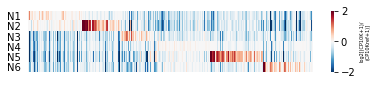

fig4k ['DC1', 'DC2', 'DC3', 'pDC']
fig4k 16 out of 400 genes missing


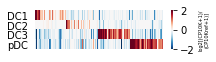

fig5g ['Mono1', 'Mono2', 'Mono3', 'Mac1', 'Mac2', 'Mac3', 'Mac4', 'MonoDC']
fig5g 24 out of 400 genes missing


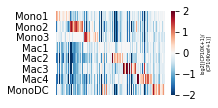

In [23]:
# loop starts here:


# for saving heatmaps as separate excel sheets
fname = 'outputs/comparison_to_Immunity_heatmaps/heatmap_data'
figname = 'outputs/comparison_to_Immunity_heatmaps/Immunity_gene_heatmap'
print(fname)
# save excel tables with data
writer = pd.ExcelWriter('%s.xlsx'%fname)


for figkey in figs:

    thelim = 2
    
    # universal code
    pops = framedict[figkey]['enriched_in'].unique()
    
    # drop that "m" in from of population labels:
    pops = [i[1:] for i in pops]
    
    print(figkey,pops)
    genes = genedict[figkey]
    cmap = plt.cm.get_cmap('RdBu_r')
    
    missing = [i for i in genes if i not in centroids.columns]
    print(figkey,len(missing),'out of',len(genes),'genes missing')
    
    genes = [i for i in genes if i not in missing]
    
    heat = centroids.copy()
    heat = heat.loc[pops,genes]
    heat = heat + pseudo
    # second normalize by second-max:
    heat = heat/heat.apply(lambda x:sorted(x)[-2])
    heat = np.log2(heat)
    
    
    # plot heatmap
    w = heat.shape[1]/100.+4
    h = heat.shape[0]*0.8+1.
    a,fig,gs = rz.startfig(w,h,rows=2)
    
    hmap = a.matshow(heat,vmin=-thelim,vmax=thelim,cmap=cmap,aspect='auto')
    rz.showspines(a)
    a.set_xticks([])
    a.set_yticks(np.arange(heat.shape[0]))
    a.set_yticklabels(heat.index)
    cbar = fig.colorbar(hmap)
    cbar.outline.set_visible(False)
    cbar.set_label('log2[(CP10K+1)/\n(CP10Kref+1)]',fontsize=5)
    gs.tight_layout(fig)
    
    # save excel
    # a bit slow...
    rz.color_dataframe_cells(heat,vmin=-thelim,vmax=thelim,cmap=cmap).\
    to_excel(writer,'Immunity_%s'%figkey) 

    plt.savefig('%s_%s.pdf'%(figname,figkey),dpi=600)
    plt.show()
    
    
writer.save()

## Plot signature scatterplots  
Collapse the same genes as in the heatmaps into signatures and color the SPRING plot by signature expression

In [24]:
!mkdir -p outputs/spring_to_check_signatures

In [25]:
def plot_signature(
        signature,
        x,y,
        s = 5,
        pctilemax = 99.5,
        vmax=None,
        w = 3,
        h = 3,
        comment = '',
        pad = 0,
        ftype = 'pdf',
        dpi = 1200.,
        save=True,
        show_cbar=False,
        savedir='.',
        ):
    
    """
    To write...
    """
    
    
    order = np.argsort(signature)
    signature = signature[order]
    
    # get selected percentile within the selected cells only
    if vmax is None:
        vmax = np.percentile(signature,pctilemax)
    print(vmax)
    vmin = 0
    
    if vmin==vmax:
        signature = '#00ff00'
    
    x = x[order]
    y = y[order]
    
    a,fig,gs=rz.startfig(w,h,frameon=False)
    
    a.set_xticks([])
    a.set_yticks([])
    
    scatter = a.scatter(x,y,lw=0,s=s,c=signature,cmap=rz.custom_colormap(['#000000','#00ff00']),vmax=vmax,vmin=vmin)
    
    if show_cbar:
        cbar = plt.colorbar(scatter,orientation='horizontal')
        cbar.outline.set_visible(False)
        cbar.set_ticks([0,vmax])
        cbar.ax.set_xticklabels(['0th','>%0.2fth'%pctilemax])
    
    gs.tight_layout(fig,pad=pad)
    
    if save:
        plt.savefig(savedir+'/scatter_%s_%.2f_pctile.%s'%(comment,pctilemax,ftype),dpi=dpi)
    plt.show()

In [26]:
#path to project directory
path1 = "/Users/rapolaszilionis/Google Drive/analyses/SPRING_dev/data/pittet"
project_dir = path1+'/CSF1Ri/'
plot_name = 'all_Cd45pos_cells/'

# load cell index
cellix = np.loadtxt(project_dir+plot_name+'/cell_filter.txt',dtype=int)

# load x,y coordinates
xy = pd.read_csv(project_dir+plot_name+'/coordinates.txt',header=None,index_col=0)
x = xy[1].values
y = -xy[2].values

In [27]:
# get dictionary of genes to plot again:
genedict2 = {}
for key in framedict.keys():
    frame = framedict[key]
    msk2 = frame.iloc[:,-2].astype(bool).values
    gdict = {}
    for pop in frame['enriched_in'].unique():
        msk1 = (frame['enriched_in'] == pop).values
        gdict[pop] = list(frame.index[msk1&msk2])
    genedict2[key] = gdict

mN1
2.152074043512342


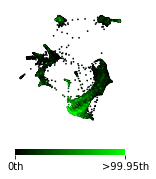




mN2
5.6911823348998585


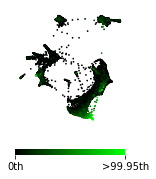




mN3
2.492729663372021


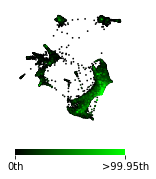




mN4
2.0966381139754784


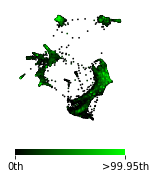




mN5
4.903310592174524


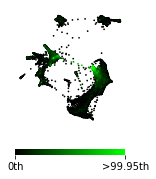




mN6
3.0166766309738122


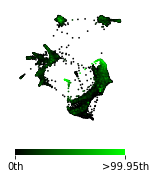




mDC1
5.98372499084469


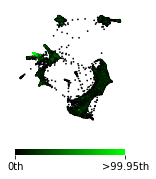




mDC2
1.6089324370622593


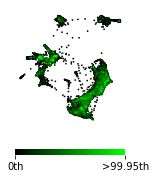




mDC3
5.424831895828225


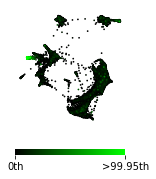




mpDC
7.219978595256801


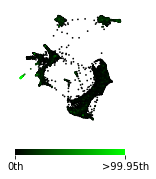




mMono1
2.9527210710048655


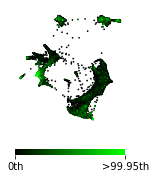




mMono2
4.98540112209319


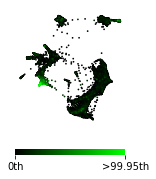




mMono3
1.9348681132793362


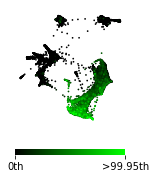




mMac1
3.063712047338444


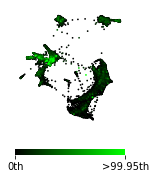




mMac2
5.627160772323593


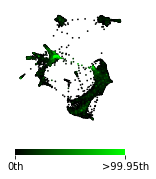




mMac3
7.090849208831773


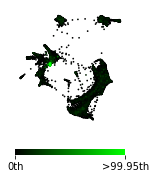




mMac4
4.542750946998552


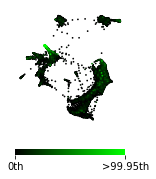




mMonoDC
4.269169014930667


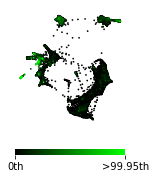

In [28]:
for figkey in figs:
    for popkey in genedict2[figkey].keys():
        #popkey = 'mN2'
        gtp = genedict2[figkey][popkey][:20]
        
        # gene mask
        gmask = np.in1d(adata.var_names,gtp)
        
        # select normalized counts
        e = adata.X[cellix,:][:,gmask].toarray()
        
        # decision: use z-scoring for combining.
        z = scipy.stats.zscore(e,axis=0)
        z = np.nan_to_num(z)
        signature = z.mean(axis=1)
        
        pctilemax = 99.95
        
        print(popkey)
        plot_signature(
                signature,
                x,y,
                w=5,h=6,
                s=3,
                pctilemax=pctilemax,
                comment = 'signature_%s_%s_v1'%(figkey,popkey),
                show_cbar = True,
                save = True,
                ftype='png',
                savedir='outputs/spring_to_check_signatures/')
        
        print('\n\n')

In [29]:
!open outputs